## Abstract: 

Element-wise comparison of records with personal data from a record linkage setting. The task is to decide from a comparison pattern whether the underlying records belong to one person.

## Data Set Information:

The records represent individual data including first and family name, sex, date of birth and postal code, which were collected through iterative insertions in the course of several years. The comparison patterns in this data set are based on a sample of 100.000 records dating from 2005 to 2008. Data pairs were classified as 'match' or 'non-match' during an extensive manual review where several documentarists were involved. The resulting classification formed the basis for assessing the quality of the 
registryâ€™s own record linkage procedure. 

In order to limit the amount of patterns, a blocking procedure was applied, 
which selects only record pairs that meet specific agreement conditions. The 
results of the following six blocking iterations were merged together: 

1. Phonetic equality of first name and family name, equality of date of birth. 
2. Phonetic equality of first name, equality of day of birth. 
3. Phonetic equality of first name, equality of month of birth. 
4. Phonetic equality of first name, equality of year of birth. 
5. Equality of complete date of birth. 
6. Phonetic equality of family name, equality of sex. 

This procedure resulted in 5.749.132 record pairs, of which 20.931 are matches. 

The data set is split into 10 blocks of (approximately) equal size and ratio 
of matches to non-matches. 

The separate file frequencies.csv contains for every predictive attribute 
the average number of values in the underlying records. These values can, for example, 
be used as u-probabilities in weight-based record linkage following the 
framework of Fellegi and Sunter.

## Attribute Information:

1. id_1: internal identifier of first record. 
2. id_2: internal identifier of second record. 
3. cmp_fname_c1: agreement of first name, first component 
4. cmp_fname_c2: agreement of first name, second component 
5. cmp_lname_c1: agreement of family name, first component 
6. cmp_lname_c2: agreement of family name, second component 
7. cmp_sex: agreement sex 
8. cmp_bd: agreement of date of birth, day component 
9. cmp_bm: agreement of date of birth, month component 
10. cmp_by: agreement of date of birth, year component 
11. cmp_plz: agreement of postal code 
12. is_match: matching status (TRUE for matches, FALSE for non-matches) 

The agreement of name components is measured as a real number in the interval [0,1], where 0 denotes maximal disagreement and 1 equality of the underlying values. For the other comparisons, only the values 0 (not equal) and 1 (equal) are used. 

is_match is the outcome variable. id_1 and id_2 are not used for prediction but could be used to construct connected components from the found matches. 

## Relevant Papers:

1. Irene Schmidtmann, Gael Hammer, Murat Sariyar, Aslihan Gerhold-Ay: 
Evaluation des Krebsregisters NRW Schwerpunkt Record Linkage. Technical 
Report, IMBEI 2009. 
[Web Link] 
-- Describes the external evaluation of the registry's record linkage 
procedures. 
-- The comparison patterns in this data set were created in course of 
this evaluation. 

2. Murat Sariyar, Andreas Borg, Klaus Pommerening: 
Controlling false match rates in record linkage using extreme value theory. 
Journal of Biomedical Informatics, 2011 (in press). 
-- Predicted attribute: matching status (boolean). 
-- Results: 
-- A new approach for estimating the false match rate in record 
linkage by methods of Extreme Value Theory (EVT). 
-- The model eliminates the need for labelled training data while 
achieving only slighter lower accuracy compared to a procedure 
that has knowledge about the matching status.



In [1]:
!pip install recordlinkage

%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import recordlinkage as rl

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 19.0.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Exploration des fichiers, comment les ouvrir et les grouper etc..

In [2]:
## Load the 10 blocks
path = 'E:/Cours/S9/Python for Data Analysis/Projet/PythonProject/modelisation/Dataset_Projet/blocks/'
blocks = []
for element in os.listdir(path):
    string = path + element
    df_b = pd.read_csv(string, encoding='utf-8', delimiter=',')
    blocks.append(df_b)
df = pd.concat([obj for obj in blocks], ignore_index=True)

## Exploration & Preprocessings

In [3]:
print(df.shape)
ids_1 = df.id_1.get_values().tolist()
ids_2 = df['id_2'].get_values().tolist()

print("Number of unique id_1: ",len(set(ids_1)), " out of rows : ", df.shape[0])
print("Number of unique id_2: ",len(set(ids_2)), " out of rows : ", df.shape[0])
print("Number of common unique id in id1 and id2 : ",len(set(ids_1).intersection(ids_2)))
mask = (df['is_match'] == True)
print("Number of TRUE matchs over this dataset", df[mask].shape[0], "over", df.shape[0]) 

(5749132, 12)
Number of unique id_1:  97282  out of rows :  5749132
Number of unique id_2:  97311  out of rows :  5749132
Number of common unique id in id1 and id2 :  94805
Number of TRUE matchs over this dataset 20931 over 5749132


In [4]:
cmp_fname_c2 = df['cmp_fname_c2'].get_values().tolist()
const_cols = [c for c in df.columns if df[c].nunique(dropna=False)==2] #No constants
#cmp_sex et is_match: boolean

In [5]:
group_by_val = df.groupby('cmp_fname_c2').count()
mask = (df['cmp_fname_c2'] != '?')
print("Il n'y a que", round((df[mask].shape[0] / df.shape[0]*100),2), "% de valeurs différentes de '?'")
#tmp = group_by_val['id_1'].get_values().tolist()
#tmp

Il n'y a que 1.8 % de valeurs différentes de '?'


In [6]:
mask = (df['is_match'] == True)
df_test = df[mask].groupby('cmp_lname_c1').count()
df_test

## En filtrant la colonne is_match à true (20931 occurences), 98,8% des valeurs ont la valeur de la colonne cmp_fname_c1 à 1, 
## ce qui indique que l'on est à peu de détails près sûr du premier nom de la personne

# Variables où l'on est "sûr" (agreement)

## 98,8% de valeurs à 1 pour cmp_fname_c1
## 99,1% de valeurs à 1 pour cmp_lname_c1
## 98,9% de valeurs à 1 pour cmp_sex
## 99,5% de valeurs à 1 pour cmp_bd
## 99,7% de valeurs à 1 pour cmp_bm
## 99,6% de valeurs à 1 pour cmp_by

# Variables où l'on est pas "sûr"

## 95,26% de valeurs à 1 pour cmp_plz
## 2,3% de valeurs à 1 pour cmp_lname_c2
## 6% de valeurs à 1 pour cmp_fname_c2


## df[mask].shape[0]

,id_1,id_2,cmp_fname_c1,cmp_fname_c2,cmp_lname_c2,cmp_sex,cmp_bd,cmp_bm,cmp_by,cmp_plz,is_match
cmp_lname_c1,,,,,,,,,,,
0.000000,17,17,17,17,17,17,17,17,17,17,17
0.083333,1,1,1,1,1,1,1,1,1,1,1
0.090909,2,2,2,2,2,2,2,2,2,2,2
0.100000,3,3,3,3,3,3,3,3,3,3,3
0.111111,1,1,1,1,1,1,1,1,1,1,1
0.125000,3,3,3,3,3,3,3,3,3,3,3
0.142857,3,3,3,3,3,3,3,3,3,3,3
0.166667,4,4,4,4,4,4,4,4,4,4,4
0.200000,1,1,1,1,1,1,1,1,1,1,1


In [7]:
def format_raws(dF):
    dF['id_1'] = dF['id_1'].astype(str)
    dF['id_2'] = dF['id_2'].astype(str)
    dF.set_index(['id_1', 'id_2'], inplace=True) #Set id_1 and id_2 as multi_index of df

    for col in dF.columns:
        dF[col].replace('?',0, inplace=True)
        dF[col] = dF[col].astype(float)
    return dF

df = format_raws(df)

In [8]:
# Some statistics of the record linkage table sample
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
cmp_fname_c1,5749132.0,0.712778,0.388839,0.0,0.285714,1.000000,1.000000,1.0
cmp_fname_c2,5749132.0,0.016234,0.125199,0.0,0.000000,0.000000,0.000000,1.0
cmp_lname_c1,5749132.0,0.315628,0.334234,0.0,0.100000,0.181818,0.428571,1.0
cmp_lname_c2,5749132.0,0.000136,0.010081,0.0,0.000000,0.000000,0.000000,1.0
cmp_sex,5749132.0,0.955001,0.207301,0.0,1.000000,1.000000,1.000000,1.0
cmp_bd,5749132.0,0.224434,0.417209,0.0,0.000000,0.000000,0.000000,1.0
cmp_bm,5749132.0,0.488788,0.499874,0.0,0.000000,0.000000,1.000000,1.0
cmp_by,5749132.0,0.222718,0.416070,0.0,0.000000,0.000000,0.000000,1.0
cmp_plz,5749132.0,0.005516,0.074067,0.0,0.000000,0.000000,0.000000,1.0
is_match,5749132.0,0.003641,0.060228,0.0,0.000000,0.000000,0.000000,1.0


In [9]:
mask = (df['is_match'] == True)
print(df[mask].shape)

def get_index_match(dF):
    tmp = []
    indexes = dF.index.tolist()
    for tup in indexes:
        line = dF.loc[tup]
        if(line.is_match == True):
            tmp.append(tup)
    return tmp
train_match = get_index_match(df)

(20931, 10)


## Deterministic Approach

In [10]:
## Frequencies used in probabilistic record linkage, yields better results than the deterministic approach
path = 'E:/Cours/S9/Python for Data Analysis/Projet/PythonProject/modelisation/Dataset_Projet/frequencies.csv'
freqs = pd.read_csv(path, encoding='utf-8', delimiter=',')
freqs.head()

,cmp_fname_c1,cmp_fname_c2,cmp_lname_c1,cmp_lname_c2,cmp_sex,cmp_bd,cmp_bm,cmp_by,cmp_plz
0,0.000235,0.001477,0.000027,0.000641,0.5,0.032258,0.083333,0.009434,0.000423


In [11]:
scores = []
itera = []

df = df.sample(frac=1)
df2 = pd.DataFrame()
df2 = df.copy(deep=True)
df2.drop(columns = 'is_match', inplace=True)

for i in range(1,20,1):
    train = df2[:(3000*i)] #Small dataset for training
    indexes = pd.MultiIndex.from_tuples(train_match, names=['id1', 'id2'])
    golden_matches_index = train.index & indexes
    # Initialize the classifier
    logreg = rl.LogisticRegressionClassifier()
    # Train the classifier
    logreg.fit(train, golden_matches_index)
    
    #print ("Coefficients: ", logreg.coefficients)
    
    # Predict the match status for all record pairs
    result_logreg = logreg.predict(df2[(3000*i):])
    print ("Intercept: ", logreg.intercept, "pour", i)
    #print(len(result_logreg))

    #print(rl.confusion_matrix(indexes, result_logreg, len(df2)))
    print('------------ITERATION = ', i, 'sur 20')
    # The F-score for this prediction is
    train_set = 3000*i
    itera.append(train_set)
    score = rl.fscore(indexes, result_logreg)
    scores.append(score)

Intercept:  -4.989549202697092 pour 1
------------ITERATION =  1 sur 20
Intercept:  -6.207609246838943 pour 2
------------ITERATION =  2 sur 20
Intercept:  -6.826008005257734 pour 3
------------ITERATION =  3 sur 20
Intercept:  -7.309825349124799 pour 4
------------ITERATION =  4 sur 20
Intercept:  -8.123565220621748 pour 5
------------ITERATION =  5 sur 20
Intercept:  -8.408684501508334 pour 6
------------ITERATION =  6 sur 20
Intercept:  -8.670438477382122 pour 7
------------ITERATION =  7 sur 20
Intercept:  -8.910686585197228 pour 8
------------ITERATION =  8 sur 20
Intercept:  -9.119627594570492 pour 9
------------ITERATION =  9 sur 20
Intercept:  -9.503339662414186 pour 10
------------ITERATION =  10 sur 20
Intercept:  -9.824759597665281 pour 11
------------ITERATION =  11 sur 20
Intercept:  -9.876192452979028 pour 12
------------ITERATION =  12 sur 20
Intercept:  -10.118604281836317 pour 13
------------ITERATION =  13 sur 20
Intercept:  -10.234966823275126 pour 14
------------ITE

In [12]:

l = [('37291', '53113'), ('37191', '83113')]

indo = pd.MultiIndex.from_tuples(l, names=['id1', 'id2'])

truc = indexes & indo
print(len(truc))
print(train.index)

1
MultiIndex(levels=[['1', '10', '100', '1000', '10000', '10001', '10002', '10003', '10004', '10005', '10006', '10007', '10008', '10009', '1001', '10010', '10011', '10012', '10013', '10014', '10015', '10016', '10017', '10018', '10019', '1002', '10020', '10021', '10022', '10023', '10024', '10025', '10026', '10027', '10028', '10029', '1003', '10030', '10031', '10032', '10033', '10034', '10035', '10036', '10037', '10038', '10039', '1004', '10040', '10041', '10042', '10043', '10044', '10045', '10046', '10047', '10048', '10049', '1005', '10050', '10051', '10052', '10053', '10054', '10055', '10056', '10057', '10058', '10059', '1006', '10060', '10061', '10062', '10063', '10064', '10065', '10066', '10067', '10068', '10069', '1007', '10070', '10071', '10072', '10073', '10074', '10075', '10076', '10077', '10078', '10079', '1008', '10080', '10081', '10082', '10083', '10084', '10085', '10086', '10087', '10088', '10089', '1009', '10090', '10091', '10092', '10093', '10094', '10095', '10096', '10097'

In [13]:
tup = (truc.levels[0][0], truc.levels[1][0])
print(tup)

('37291', '53113')


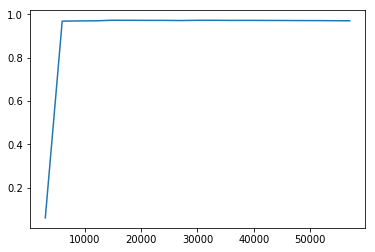

In [14]:
# We want to know the optimal set of training data to train the logistic regression classifier
plt.plot(itera, scores)
# Around 30 000 records

In [15]:
train = df2[:30000]

# Initialize the classifier
logreg = rl.LogisticRegressionClassifier()
# Train the classifier
logreg.fit(train, golden_matches_index)
print ("Intercept: ", logreg.intercept)
print ("Coefficients: ", logreg.coefficients)

Intercept:  -9.503339662414186
Coefficients:  [ 1.53267047  0.71564179  3.8844317   0.29525164 -1.92531407  1.47961409
  0.66343385  1.45621669  4.89726235]


In [16]:
# Predict the match status for all record pairs
result_logreg = logreg.predict(df2[30000:])

print(len(result_logreg))

print(rl.confusion_matrix(indexes, result_logreg, len(df2)))

19961
[[  19868    1063]
 [     93 5728108]]


In [17]:
# The F-score for this prediction is
rl.fscore(indexes, result_logreg)

0.9717304118164922

## Probabilistic approach

Add the coeff that are in frequencies.csv to the algorithms. We want to weight the variables that would help predict if the first and last names in one record (row) corresponds to the same person.

In [18]:
intercept = -9

coeffs = freqs.get_values().tolist()
coeffs = coeffs[0]

logreg = rl.LogisticRegressionClassifier(coeffs, intercept)

logreg.fit(train, golden_matches_index)
print ("Intercept: ", logreg.intercept)
print ("Coefficients: ", logreg.coefficients)

result_logreg_pretrained = logreg.predict(df2[30000:])
print (len(result_logreg_pretrained))

Intercept:  -9.503339662414186
Coefficients:  [ 1.53267047  0.71564179  3.8844317   0.29525164 -1.92531407  1.47961409
  0.66343385  1.45621669  4.89726235]
19961


In [19]:
# The confusion matrix is
print(rl.confusion_matrix(indexes, result_logreg_pretrained, len(df2)))
# The F-score for this classification is
print(rl.fscore(indexes, result_logreg_pretrained))

[[  19868    1063]
 [     93 5728108]]
0.9717304118164922


In [20]:
# Train the classifier
nb = rl.NaiveBayesClassifier(binarize=0.3)
nb.fit(train, golden_matches_index)

# Predict the match status for all record pairs
result_nb = nb.predict(df2[30000:])

print(len(result_nb))
# The confusion matrix is
print(rl.confusion_matrix(indexes, result_nb, len(df2)))
# The F-score for this classification is
print("F_score:",rl.fscore(indexes, result_nb))
# The precision for this classification is:
print("Précision:",rl.precision(indexes, result_nb), '%')
# The recall for this classification is:
print("Rappel:",rl.recall(indexes, result_nb), '%')

19752
[[  19740    1191]
 [     12 5728189]]
F_score: 0.9704299092987243
Précision: 0.9993924665856622 %
Rappel: 0.9430987530457217 %


## Optimized SVM for Record Linkage

In [21]:
# Train the classifier
svm = rl.SVMClassifier()
svm.fit(train, golden_matches_index)

# Predict the match status for all record pairs
result_svm = svm.predict(df2[30000:])

print(len(result_svm))
# The confusion matrix is

test = rl.confusion_matrix(indexes, result_svm, len(df2))
print(rl.confusion_matrix(indexes, result_svm, len(df2)))
# The F-score for this classification is
print("F_score:",rl.fscore(indexes, result_svm))
# The precision for this classification is:
print("Précision:",rl.precision(indexes, result_svm), '%')
# The recall for this classification is:
print("Rappel:",rl.recall(indexes, result_svm), '%')

##Better results yielded by the SVM algorithm

20729
[[  20719     212]
 [     10 5728191]]
F_score: 0.9946711473835813
Précision: 0.9995175840609773 %
Rappel: 0.9898714824900865 %


## SVM with Grid Search

In [22]:
print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


Y = df['is_match'].get_values().tolist()

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(df2, Y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel='linear', C=0.01)
y_pred = classifier.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


matrix = confusion_matrix(y_test, y_pred)
# Compute confusion matrix
cnf_matrix = matrix
np.set_printoptions(precision=2)



Automatically created module for IPython interactive environment


In [25]:
from sklearn.metrics import f1_score, accuracy_score, recall_score

Confusion matrix, without normalization
[[1431954       4]
 [     21    5304]]
Normalized confusion matrix
[[1.00e+00 2.79e-06]
 [3.94e-03 9.96e-01]]


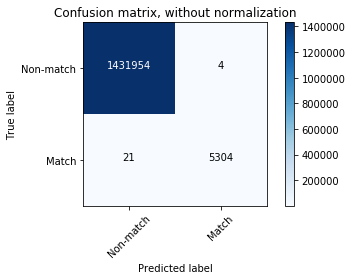

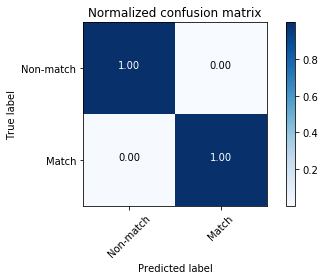

f1-score: 0.9976488291169002
accuracy: 0.999982606069925
recall: 0.9960563380281691


In [27]:
# Plot non-normalized confusion matrix
class_names = ['Non-match', 'Match']

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

f1 = f1_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)


print("f1-score:", f1)
print("accuracy:", acc)
print("recall:", recall)
# These are the results done on the test_set

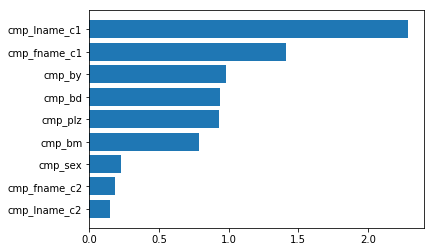

None


In [28]:
# Better precision with the sklearn's SVM
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

features_names = df2.columns.get_values().tolist()

print(f_importances(classifier.coef_[0], features_names))


As we can see on the graph above, predicting that one record corresponds to one person is merely due to the family name in the first table.
In the exploration part we saw that we had 99% of the values set to 1.0 in the variables cmp_lname_c1 when filtering on true matches. A value between 0 and 1 is about incertitude of the value. That's why the feature importance prioritize this predictor.
We have the same case for first names (99% of values set to 1 when grouping on true matches), but as more people share a firstname than a lastname with the others, it's a less important feature to predict. For example it's more difficult to predict that two 'Kevin' with different id1 and id2 on a record pair, corresponds to the same person than comparing it's last names values.
In fact, the real meaningful predictors are cmp_by, cmp_plz, cmp_bd, cmp_bm, cmp_sex.
On the other hand the birth date (cmp_by) is a very informative feature to affirm that a person with id1 and id2 is the same person.

In [58]:
from __future__ import print_function

from sklearn.metrics import classification_report

print(__doc__)

X = df2

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.5, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(svm.SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for precision



KeyboardInterrupt: 